# CIFAR-10 Analysis - No Noise

---

- Architecture: Resnet 20
- Data Augmentation:Horizontal Flip, Shift, Cutout
- New LR Schedule

<p> Based On: https://github.com/keras-team/keras/blob/master/examples/cifar10_resnet.py
      


## Strategy:
- Repeat Experiment 3 times (using only 17.5K steps)* 
- Observe Variability in Validation Accuracy

## Results:
- Variability is not significant: (0.910, 0.904, 0.910)

<p> * <i>A better fit is obtained elsewhere with more training steps (hence, longer run completion).</i>

# Load Data and Libraries

In [0]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, MaxPooling2D, Input, Flatten, concatenate
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [0]:
# Model version
# Orig paper: version = 1 (ResNet v1)

version = 1
n = 3
depth = n * 6 + 2

num_classes = 10

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [0]:
# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]

In [0]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [62]:
x_train_mean = np.mean(x_train, axis=(0,1,2))
x_train -= x_train_mean
x_test -= x_train_mean
x_train_std = np.std(x_train, axis=(0,1,2))
x_train /= x_train_std
x_test  /= x_train_std

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)


In [0]:
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# Model Architecture

In [0]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Train Model

In [66]:
hyper = {'lr':0.16,'rho':0.93,'alpha':1.5e-4,'augmentation_factor':1.5,'batch_size':128}

BATCHES_PER_EPOCH = hyper['augmentation_factor'] * x_train.shape[0] // hyper['batch_size']
BATCHES_PER_EPOCH

585.0

## Optimizer Settings for Super Convergence

In [0]:
class SuperConvergence(keras.callbacks.Callback):
  def __init__(self, epoch_domain=[0, 15, 30, 40],
               lr_range = [0, 0.1, 0.005, 0], echo=False):
    super().__init__()
    self.epoch_domain = epoch_domain
    self.lr_range = lr_range
    self.lr_schedule  = lambda step: np.interp(step/BATCHES_PER_EPOCH, self.epoch_domain, self.lr_range)
    self.step = 0
    self.echo = echo
    
  def on_batch_begin(self, batch, logs=None):
    keras.backend.set_value(self.model.optimizer.lr, self.lr_schedule(self.step))
    self.step += 1
    
  def on_epoch_end(self, epoch, logs=None):
    if self.echo:
      lr = keras.backend.get_value(self.model.optimizer.lr)
      print('Learning Rate: {:.4f}'.format(lr))
  
  def epochs(self):
    return self.epoch_domain[-1]
  
  def __repr__(self):
    s = 'SuperConvergence('
    s += 'epoch_domain={}, '.format(self.epoch_domain)
    s += 'lr_range={}, '.format(self.lr_range)
    s += 'echo={})'.format(self.echo)
    return s

## Data Augmentation Generator

In [0]:
def fit_cutout(train_image, channels_last=True, cutout_pxl = 8):
    try:
        shape = train_image.shape
        if train_image.ndim != 3:
            raise Exception('Expecting 3D Image')
    except AttributeError:
        print('Expecting train_image input to be numpy array')
        raise

    if channels_last:
        img_h, img_w, img_c = shape
    else:
        img_c, img_h, img_w = shape
        
    sq_side_half = np.round(cutout_pxl / 2).astype('int')
    
    def preprocess(image):
      
        new_image = image.copy()
        
        h = np.random.randint(img_h)
        w = np.random.randint(img_w)
        
        h_lo = max(0,h-sq_side_half)
        h_hi = min(img_h,h+sq_side_half)
        
        w_lo = max(0,w-sq_side_half)
        w_hi = min(img_w,w+sq_side_half)
        
        value = np.random.uniform(0,1,(3,))

        if channels_last:
            new_image[h_lo:h_hi,w_lo:w_hi,:] = value[np.newaxis,np.newaxis,:]
        else:
            new_image[:,h_lo:h_hi,w_lo:w_hi] = value[:,np.newaxis,np.newaxis]
        return new_image
    return preprocess
  
cutout = fit_cutout(x_train[0])

In [0]:
#data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    #zoom_range=[0.8,1.4],
    #rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    #brightness_range=[.15,1.15], 
    #shear_range=15,
    #channel_shift_range=0.2,
    preprocessing_function = cutout,
    fill_mode='reflect'
    )

## Model Definition


In [0]:
def prep_model(lr,rho,alpha,**kwargs):
  keras.backend.clear_session()
  model = resnet_v1(input_shape=input_shape, depth=depth)
  model.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.SGD(momentum=rho, nesterov=True),
                metrics=['accuracy'])

  for layer in model.layers:
      if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
          layer.add_loss(keras.regularizers.l2(alpha)(layer.kernel))
      if hasattr(layer, 'bias_regularizer') and layer.use_bias:
          layer.add_loss(keras.regularizers.l2(alpha)(layer.bias))
          
  optim_sched = SuperConvergence(
      epoch_domain=[0, 5, 30], lr_range = [0, lr, 0]
  )
  
          
  return model, optim_sched

In [0]:
# save as JSON
pickle.dump( model.to_json(), open( model_type+"_model_json.pkl", "wb" ) )

## Fit Model Many Times

In [72]:
collect = []
for rep in range(3):
  model, turbo = prep_model(**hyper)
  hist = model.fit_generator(
      datagen.flow(x_train, y_train, batch_size=hyper['batch_size']),
      steps_per_epoch = BATCHES_PER_EPOCH,
      validation_data=(x_test, y_test),
      epochs=turbo.epochs(), verbose=2, 
      callbacks=[turbo]
  )
  model.save_weights(model_type+'_weights_rep{}.h5'.format(rep))
  collect.append(hist.history)
  print('\n\nRep ',rep+1,' Max Validation Accuracy = ',
        np.max(hist.history['val_acc']),"\n")

Epoch 1/30
 - 60s - loss: 1.8375 - acc: 0.4045 - val_loss: 1.8161 - val_acc: 0.4647
Epoch 2/30
 - 56s - loss: 1.2772 - acc: 0.6023 - val_loss: 2.0482 - val_acc: 0.4437
Epoch 3/30
 - 56s - loss: 1.0843 - acc: 0.6789 - val_loss: 1.5202 - val_acc: 0.5856
Epoch 4/30
 - 56s - loss: 0.9978 - acc: 0.7190 - val_loss: 1.1386 - val_acc: 0.6768
Epoch 5/30
 - 56s - loss: 0.9647 - acc: 0.7372 - val_loss: 1.1749 - val_acc: 0.6569
Epoch 6/30
 - 56s - loss: 0.9331 - acc: 0.7530 - val_loss: 1.0644 - val_acc: 0.7093
Epoch 7/30
 - 56s - loss: 0.8949 - acc: 0.7705 - val_loss: 1.0942 - val_acc: 0.7169
Epoch 8/30
 - 56s - loss: 0.8647 - acc: 0.7821 - val_loss: 1.5160 - val_acc: 0.6354
Epoch 9/30
 - 56s - loss: 0.8324 - acc: 0.7939 - val_loss: 1.1365 - val_acc: 0.7216
Epoch 10/30
 - 56s - loss: 0.8106 - acc: 0.8008 - val_loss: 1.0421 - val_acc: 0.7479
Epoch 11/30
 - 56s - loss: 0.7849 - acc: 0.8107 - val_loss: 1.0068 - val_acc: 0.7567
Epoch 12/30
 - 56s - loss: 0.7722 - acc: 0.8145 - val_loss: 0.9255 - val_a

# Variability Analysis

In [73]:
print('Parameters: ',hyper)

Parameters:  {'lr': 0.16, 'rho': 0.93, 'alpha': 0.00015, 'augmentation_factor': 1.5, 'batch_size': 128}


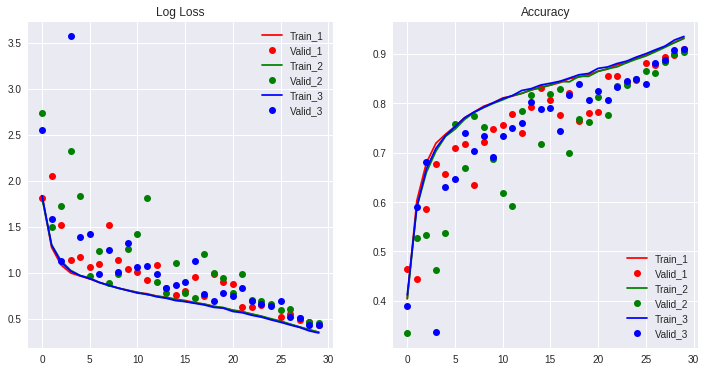

In [74]:
fig, ax = plt.subplots(1,2,figsize=(12,6))
colors_ = ['r','g','b','k','m','c','y']
for i,h in enumerate(collect):
  ax[0].plot(h['loss'],colors_[i]+"-",label='Train_{}'.format(i+1))
  ax[0].plot(h['val_loss'],colors_[i]+"o",label='Valid_{}'.format(i+1))
  ax[0].legend()
  ax[0].set_title('Log Loss')
for i,h in enumerate(collect):
  ax[1].plot(h['acc'],colors_[i]+"-",label='Train_{}'.format(i+1))
  ax[1].plot(h['val_acc'],colors_[i]+"o",label='Valid_{}'.format(i+1))
  ax[1].legend()
  ax[1].set_title('Accuracy')
               
plt.show()

In [75]:
tmp = pd.DataFrame([h['val_acc'][-10:] for h in collect])
tmp

,0,1,2,3,4,5,6,7,8,9
0,0.7821,0.8550,0.8557,0.8423,0.8468,0.8818,0.8774,0.8927,0.8986,0.9099
1,0.8120,0.7769,0.8359,0.8376,0.8484,0.8643,0.8611,0.8843,0.8999,0.9043
2,0.8239,0.8075,0.8332,0.8447,0.8484,0.8388,0.8813,0.8866,0.9074,0.9108


In [76]:
np.std(tmp)

0    0.017584
1    0.032132
2    0.010031
3    0.002949
4    0.000754
5    0.017656
6    0.008749
7    0.003544
8    0.003878
9    0.002876
dtype: float64